In [1]:
# necessary libraries, functions, and constants
import csv
import itertools
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from PIL import Image
from scipy.stats import norm
from sklearn import discriminant_analysis
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import neighbors
from timeit import default_timer as timer

classes = ['ocean', 'ship', 'shore', 'sky']

# options
oversample = False


def prepare_data(input_file, description, oversample=False):
    """
    prepares the data, also prints some information about it
    """
    y = []
    X = []
    y_numeric = []
    y_binary = []
    y_binary_numeric = []
    
    print("\n##############\n%s Data summary:" % (description))
    with open(input_file, 'r') as csvfile:
        data_reader = csv.reader(csvfile, dialect='excel')
        for row in data_reader:
            if len(row) > 0:
                y.append(row[0])
                X_float = [ float(x) for x in row[1:] ]
                X.append(X_float)
                if row[0] in ('ship', 'shore'):
                    y_binary.append('obstacle')
                else:
                    y_binary.append('non-obstacle')

    # create a y_numeric for use with tensorflow
    for obs in y:
        y_numeric.append(classes.index(obs))
        
    
    # create a y_binary_numeric for binary classification in TF
    binary_classes = ['non-obstacle', 'obstacle']
    for obs in y_binary:
        y_binary_numeric.append(binary_classes.index(obs))

    assert len(X) == len(y) == len(y_numeric) == len(y_binary) == len(y_binary_numeric)

    # convert to np.array objects
    y = np.array(y)
    y_numeric = np.array(y_numeric)
    X = np.array(X)
    y_binary = np.array(y_binary)
    y_binary_numeric = np.array(y_binary_numeric)

    # how many features?
    num_features = len(X[0])
    print("%s features" % (num_features))

    # count the classes
    largest_class = "none"
    largest_class_count = -1

    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))

    for key in class_counts.keys():
        count = class_counts[key]
        if count > largest_class_count:
            largest_class_count = count
            largest_class = key

    # raw data stats            
    print("Raw observations:")
    print("%s observations" % (len(y)))
    print("Class counts:")
    for cl in class_counts.keys():
        print("%s - %s" % (cl, class_counts[cl]))

    # if desired, use oversampling for any class that has less than 75% of the observations
    # of the largest class
    if oversample == True:
        print("\nOversampling enabled")
        print("Largest class is " + largest_class + " with %s observations" % (largest_class_count))

        for cl in class_counts.keys():
            if class_counts[cl] < 0.8 * largest_class_count:
                # oversample
                X, y = oversample(X, y, cl, largest_class_count)

        class_counts = {}
        for cl in classes:
            class_counts[cl] = y.count(cl)

        print("\nObservations after oversampling:")
        for cl in class_counts.keys():
            print("%s - %s" % (cl, class_counts[cl]))
    
    return X, y, y_numeric, y_binary, y_binary_numeric


# this function taken from:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() * 0.75
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{0:.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

    
def oversample(X, y, cl, largest_class):
    """
    returns new X and y lists with oversampling
    """
    X_new = list(X)
    y_new = list(y)
    
    # first count each class in y
    class_count = y.count(cl)
    obs_add = largest_class - class_count
    print("oversample - %s samples with %s class in y, adding %s observations" % (class_count, cl, obs_add))
    
    # keep adding samples for the class
    obs_added = 0
    class_index = 0
    all_in_class = [i for i, x in enumerate(y) if x == cl ] # => [1, 4, 6], all indexes for the class
    assert len(all_in_class) > 0
    
    # take observations from the class sequentially, looping around when off the end
    while obs_added < obs_add:
        index = all_in_class[class_index]
        
        y_new.append(y[index])
        X_new.append(X[index])
        
        obs_added += 1
        
        class_index += 1
        if class_index >= len(all_in_class):
            class_index = 0
    
    return X_new, y_new


def next_batch(X, y, offset, step):
    """
    returns a batch of observations and new offset, given offset and step
    if the batch will run off the end, loops back around
    """
    X_batch = []
    y_batch = []
    
    assert len(X) == len(y)
    
    if offset + step >= len(X):
        new_offset = offset + step - len(X)
        X_batch = list(X[offset:])
        X_batch.extend(list(X[:new_offset]))
        y_batch = list(y[offset:])
        y_batch.extend(list(y[:new_offset]))
    else:
        new_offset = offset + step
        X_batch = X[offset:offset + step]
        y_batch = y[offset:offset + step]
    
    return X_batch, y_batch, new_offset


def one_hot(y, classes):
    """
    takes as input a list of response values as strings, returns
    a one-hot matrix given the class ordering provided, and the map
    to return the index to classes
    """
    class_map = {}
    for i, cl in enumerate(classes):
        class_map[i] = cl
        
    one_hot_matrix = []
    for response in y:
        row = [0] * len(classes)
        row[classes.index(response)] = 1
        one_hot_matrix.append(row)
    
    one_hot_matrix = np.array(one_hot_matrix)
    return one_hot_matrix, class_map
    

In [2]:
# import data from data.csv
y_rgb = []
X_rgb = []
y_rgb_numeric = []
y_rgb_binary = []
r_rgb_binary_numeric = []

y_gray = []
X_gray = []
y_gray_numeric = []
y_gray_binary = []
y_gray_binary_numeric = []

X_rgb, y_rgb, y_rgb_numeric, y_rgb_binary, y_rgb_binary_numeric = prepare_data("data_rgb.csv", "RGB 32x32")
X_gray, y_gray, y_gray_numeric, y_gray_binary, y_gray_binary_numeric = prepare_data("data_gray.csv", "Grayscale 28x28")

feature_sample = {}
# some information about the features
# get 100 samples from each of the classes
for cl in classes:
    sample_red = []
    sample_green = []
    sample_blue = []
    sample_gray = []
    
    i = 0
    while len(sample_red) < 200:
        cla = y_rgb[i]
        if cla == cl:
            # add the average of RGB values for each observation
            sample = X_rgb[i][0::3]
            sample_red.append(sum(sample)/len(sample))
            sample = X_rgb[i][1::3]
            sample_green.append(sum(sample)/len(sample))
            sample = X_rgb[i][2::3]
            sample_blue.append(sum(sample)/len(sample))
            sample = X_gray[i]
            sample_gray.append(sum(sample)/len(sample))
        i += 1
    
    # add samples to the feature_sample
    feature_sample[cl] = [sample_red, sample_green, sample_blue, sample_gray]

print("len of feature_sample = %d, length of sample = %d, length of color sample = %d" % (len(feature_sample), 
                                                                                          len(feature_sample['ship']),
                                                                                          len(feature_sample['ship'][0])))
#print(feature_sample)



##############
RGB 32x32 Data summary:
3072 features
Raw observations:
4140 observations
Class counts:
shore - 793
ship - 2347
ocean - 504
sky - 496

##############
Grayscale 28x28 Data summary:
784 features
Raw observations:
4140 observations
Class counts:
shore - 793
ship - 2347
ocean - 504
sky - 496
len of feature_sample = 4, length of sample = 4, length of color sample = 200


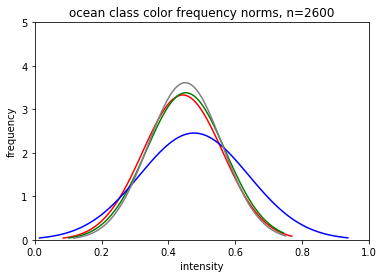

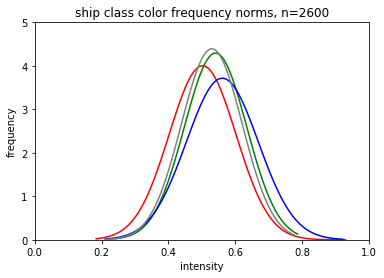

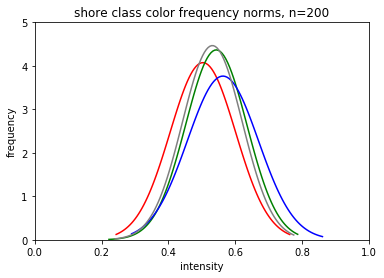

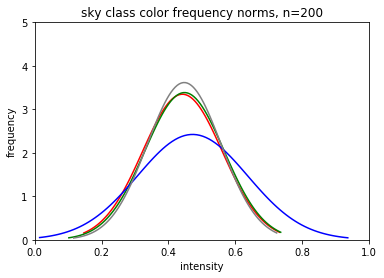

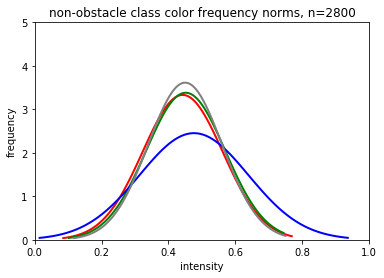

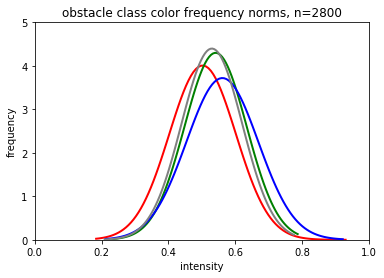

In [77]:
def color_histogram(samples, class_names, super_class_name=''):
    # plot some histograms for colors
    num_bins = 100
    
    
    if len(class_names) == 1:
        class_name = class_names[0]
        # red
        n, bins, patches = plt.hist(samples[class_name][0], num_bins, color='white', histtype='step')
        (mu,sigma) = norm.fit(samples[class_name][0])
        y_plot = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y_plot, 'r-')

        # green
        n, bins, patches = plt.hist(samples[class_name][1], num_bins, color='white', histtype='step')
        (mu,sigma) = norm.fit(samples[class_name][1])
        y_plot = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y_plot,'g-')

        # blue
        n, bins, patches = plt.hist(samples[class_name][2], num_bins, color='white', histtype='step')
        (mu,sigma) = norm.fit(samples[class_name][2])
        y_plot = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y_plot,'b-')

        # gray
        n, bins, patches = plt.hist(samples[class_name][3], num_bins, color='white', histtype='step')
        (mu,sigma) = norm.fit(samples[class_name][3])
        y_plot = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y_plot,'gray')

        # set axis limits
        axes = plt.gca()
        axes.set_xlim([0,1])
        axes.set_ylim([0,5])
    
        plt.title("%s class color frequency norms, n=%d" % (class_name, len(samples[class_name][0]) ))
    else:
        # red
        red_data = samples[class_names[0]][0]
        red_data.extend(samples[class_names[1]][0])
        n, bins, patches = plt.hist(red_data, num_bins, color='white', histtype='step')
        (mu,sigma) = norm.fit(red_data)
        y_plot = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins,y_plot,'r-',linewidth=2)

        # green
        green_data = samples[class_names[0]][1]
        green_data.extend(samples[class_names[1]][1])
        n, bins, patches = plt.hist(green_data, num_bins, color='white', histtype='step')
        (mu,sigma) = norm.fit(green_data)
        y_plot = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins,y_plot,'g-',linewidth=2)

        # blue
        green_data = samples[class_names[0]][2]
        green_data.extend(samples[class_names[1]][2])
        n, bins, patches = plt.hist(green_data, num_bins, color='white', histtype='step')
        (mu,sigma) = norm.fit(green_data)
        y_plot = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins,y_plot,'b-',linewidth=2)

        # gray
        gray_data = samples[class_names[0]][3]
        gray_data.extend(samples[class_names[1]][3])
        n, bins, patches = plt.hist(gray_data, num_bins, color='white', histtype='step')
        (mu,sigma) = norm.fit(gray_data)
        y_plot = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins,y_plot,'gray',linewidth=2)
        
        # set axis limits
        axes = plt.gca()
        axes.set_xlim([0,1])
        axes.set_ylim([0,5])
        
        plt.title("%s class color frequency norms, n=%d" % (super_class_name, len(gray_data)))
    
    plt.xlabel("intensity")
    plt.ylabel("frequency")
    plt.show()

    
# color histograms for sub-classes
color_histogram(feature_sample, ['ocean'])
color_histogram(feature_sample, ['ship'])
color_histogram(feature_sample, ['shore'])
color_histogram(feature_sample, ['sky'])

# color histograms for classes
color_histogram(feature_sample, ['ocean', 'sky'], 'non-obstacle')
color_histogram(feature_sample, ['ship', 'shore'], 'obstacle')




In [3]:
# create training and test sets
# first method - split data set into two random sets
# randomly select from the original data into training and test sets

# validation sets
# cross-validate the validation set sizes
test_set_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def generate_validation_sets(X, y, test_size):
    """
    generates training and test sets using validation set split, given the test_size variable,
    which is a float between 0 and 1
    """
    print("generating train/test split with test size = %s" % (test_size))
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                        y, 
                                                                        test_size=test_size, 
                                                                        random_state=0)
    return X_train, y_train, X_test, y_test

# K-Nearest Neighbors
Inputs: number of neighbors, training and test sets

Outputs: accuracy score, confusion matrix

In [5]:
def knn(X_train, y_train, X_test, y_test):
    """
    Performs K-nearest Neighbors with provided parameters, returns a tuple containing
    k, accuracy, precision, confusion matrix
    """
    # record metrics for the cross-validated value - n-neighbors
    # format of knn_metrics is [index, neighbors, score, confusion matrix]
    # score is the mean accuracy and is provided by the score function of the classifier
    knn_metrics = pd.DataFrame(columns=('neighbors', 'mean_accuracy', 'confusion matrix'))
    
    max_k = int(math.sqrt(len(X_train))/2)
    #max_k = 4
    print("max k = " + str(max_k))

    # TODO - look into parallelizing this
    i = 0
    for k in range(1, max_k + 1):
        start = timer()
        
        classifier = neighbors.KNeighborsClassifier(k, 'distance', n_jobs=-1)
        classifier.fit(X_train, y_train)

        y_prediction = classifier.predict(X_test)
        cm = metrics.confusion_matrix(y_test, y_prediction, labels=classes)
        mean_accuracy = classifier.score(X_test, y_test)
        #obstacle_accuracy = cm
        
        end = timer()
        
        metric = (k, mean_accuracy, cm)
        if k == 1 or k%5 == 0:
            print("k = %s, metric = %s (%ss)" % (k, metric, end - start))
        knn_metrics.loc[i] = metric
        i += 1
    
    return knn_metrics

knn_metrics_rgb = {}
knn_metrics_gray = {}

for t in test_set_sizes:
    print("\n####################\ntest set size = %s" % (t))
    # generate validation sets
    X_train_rgb, y_train_rgb, X_test_rgb, y_test_rgb = generate_validation_sets(X_rgb, y_rgb, t)
    X_train_gray, y_train_gray, X_test_gray, y_test_gray = generate_validation_sets(X_gray, y_gray, t)
    
    # generate metrics for knn for rgb and gray-scale
    print("Color:")
    knn_metrics_rgb[t] = knn(X_train_rgb, y_train_rgb, X_test_rgb, y_test_rgb)
    print("Grayscale:")
    knn_metrics_gray[t] = knn(X_train_gray, y_train_gray, X_test_gray, y_test_gray)


####################
test set size = 0.1
generating train/test split with test size = 0.1
generating train/test split with test size = 0.1
Color:
max k = 30
k = 1, metric = (1, 0.6908212560386473, array([[ 17,   8,   6,  12],
       [ 19, 202,   7,   8],
       [ 18,  10,  30,  10],
       [ 16,   5,   9,  37]])) (16.22970657591827s)
k = 5, metric = (5, 0.70772946859903385, array([[ 19,   9,  10,   5],
       [ 21, 201,  10,   4],
       [ 15,  12,  36,   5],
       [ 16,   9,   5,  37]])) (16.27668729809875s)
k = 10, metric = (10, 0.69565217391304346, array([[ 14,  15,   9,   5],
       [ 17, 202,  13,   4],
       [ 10,  16,  35,   7],
       [ 11,  12,   7,  37]])) (16.160605961242027s)
k = 15, metric = (15, 0.70048309178743962, array([[ 15,  15,  10,   3],
       [ 17, 206,   7,   6],
       [ 11,  17,  33,   7],
       [ 14,  12,   5,  36]])) (16.528638605969945s)
k = 20, metric = (20, 0.68599033816425126, array([[ 15,  16,   8,   4],
       [ 19, 202,   8,   7],
       [ 14,  16

k = 20, metric = (20, 0.70048309178743962, array([[ 94,  62,  22,  28],
       [ 68, 824,  22,  21],
       [ 77,  66, 142,  23],
       [ 40,  50,  17, 100]])) (47.83168678254333s)
Grayscale:
max k = 24
k = 1, metric = (1, 0.64975845410628019, array([[ 85,  44,  45,  32],
       [ 73, 775,  50,  37],
       [ 90,  77, 114,  27],
       [ 38,  43,  24, 102]])) (11.626833925201936s)
k = 5, metric = (5, 0.65760869565217395, array([[ 73,  66,  44,  23],
       [ 52, 812,  40,  31],
       [ 83,  87, 112,  26],
       [ 28,  67,  20,  92]])) (12.148683793112468s)
k = 10, metric = (10, 0.65036231884057971, array([[ 69,  85,  31,  21],
       [ 40, 829,  40,  26],
       [ 84, 108,  97,  19],
       [ 26,  77,  22,  82]])) (12.318147824928928s)
k = 15, metric = (15, 0.65458937198067635, array([[ 64,  93,  29,  20],
       [ 38, 838,  28,  31],
       [ 76, 116, 102,  14],
       [ 19,  83,  25,  80]])) (12.365751954270308s)
k = 20, metric = (20, 0.64553140096618356, array([[ 58, 103,  29,  1

k = 10, metric = (10, 0.61322463768115942, array([[  77,  239,   63,   33],
       [  54, 1686,   50,   63],
       [ 102,  345,  133,   55],
       [  28,  224,   25,  135]])) (7.506155651888548s)

####################
test set size = 0.9
generating train/test split with test size = 0.9
generating train/test split with test size = 0.9
Color:
max k = 10
k = 1, metric = (1, 0.6127214170692431, array([[ 134,  114,  130,   82],
       [ 168, 1647,  163,  111],
       [ 209,  149,  297,   65],
       [  74,  101,   77,  205]])) (16.762690069061136s)
k = 5, metric = (5, 0.6427804616210413, array([[ 115,  145,  146,   54],
       [ 101, 1770,  156,   62],
       [ 156,  181,  319,   64],
       [  64,  125,   77,  191]])) (16.566926393312315s)
k = 10, metric = (10, 0.65190552871712293, array([[  56,  206,  155,   43],
       [  39, 1860,  139,   51],
       [  77,  246,  345,   52],
       [  44,  169,   76,  168]])) (17.261230909143706s)
Grayscale:
max k = 10
k = 1, metric = (1, 0.579173376

         0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
0   0.690821  0.654589  0.672303  0.671498  0.662802  0.674718  0.660801   
1   0.690821  0.654589  0.672303  0.671498  0.662802  0.674718  0.660801   
2   0.700483  0.669082  0.687601  0.687802  0.683575  0.684783  0.664251   
3   0.695652  0.677536  0.696457  0.695652  0.694203  0.685990  0.668737   
4   0.707729  0.682367  0.698873  0.703502  0.692271  0.686795  0.673913   
5   0.710145  0.693237  0.706119  0.696256  0.690821  0.693639  0.680814   
6   0.700483  0.685990  0.698068  0.693237  0.686957  0.692029  0.683575   
7   0.698068  0.695652  0.701288  0.700483  0.688406  0.693237  0.685990   
8   0.693237  0.679952  0.698068  0.696860  0.690338  0.694042  0.682885   
9   0.695652  0.679952  0.695652  0.692633  0.692754  0.692432  0.687716   
10  0.693237  0.682367  0.690821  0.699275  0.691304  0.693639  0.687371   
11  0.683575  0.687198  0.693237  0.698068  0.695652  0.702496  0.689096   
12  0.681159

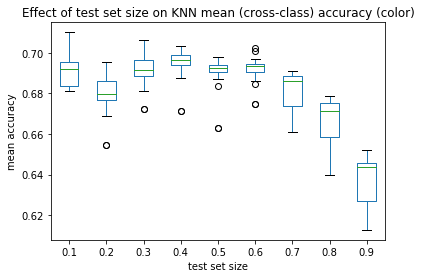

         0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
0   0.632850  0.613527  0.634461  0.649758  0.635749  0.640902  0.633540   
1   0.632850  0.613527  0.634461  0.649758  0.635749  0.640902  0.633540   
2   0.652174  0.620773  0.641707  0.653986  0.644928  0.641707  0.633195   
3   0.666667  0.640097  0.660225  0.663043  0.645411  0.642110  0.632160   
4   0.657005  0.624396  0.652174  0.657609  0.644928  0.644525  0.634231   
5   0.681159  0.642512  0.654589  0.650966  0.642995  0.650564  0.638716   
6   0.676329  0.642512  0.659420  0.661836  0.644444  0.641707  0.628019   
7   0.673913  0.648551  0.656200  0.654589  0.640097  0.640499  0.629055   
8   0.673913  0.634058  0.661031  0.654589  0.635749  0.638084  0.634576   
9   0.671498  0.637681  0.656200  0.650362  0.639130  0.635668  0.630090   
10  0.654589  0.647343  0.645733  0.653382  0.636715  0.634461  0.631125   
11  0.654589  0.638889  0.652174  0.657609  0.629952  0.636473  0.630780   
12  0.652174

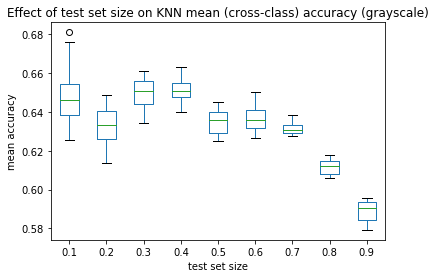

Normalized confusion matrix
[[ 0.44186047  0.30232558  0.13953488  0.11627907]
 [ 0.08898305  0.85169492  0.04661017  0.01271186]
 [ 0.17647059  0.19117647  0.54411765  0.08823529]
 [ 0.20895522  0.13432836  0.10447761  0.55223881]]


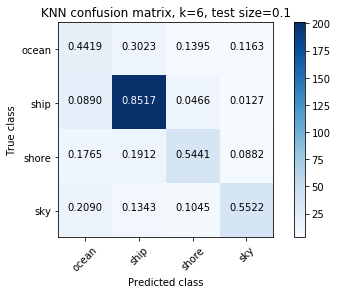

Normalized confusion matrix
[[ 0.23255814  0.3255814   0.30232558  0.13953488]
 [ 0.03813559  0.90677966  0.03813559  0.01694915]
 [ 0.22058824  0.29411765  0.38235294  0.10294118]
 [ 0.11940299  0.29850746  0.10447761  0.47761194]]


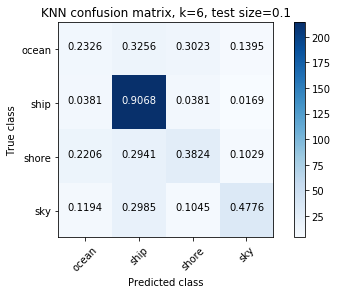

In [60]:
# determine mean mean accuracy for each test set size
#print(knn_metrics_rgb)[0.1].loc(5)
#print(knn_metrics_gray)

mean_mean_accuracies = {}
highest_mean_accuracy_rgb = -1
best_test_size_rgb = -1
highest_accuracy_rgb = -1
highest_accuracy_test_size_rgb = -1

highest_mean_accuracy_gray = -1
best_test_size_gray = -1
highest_accuracy_gray = -1
highest_accuracy_test_size_gray = -1

#for key in knn_metrics_rgb.keys():
#    means = knn_metrics_rgb[key].mean()
#    maxes = knn_metrics_rgb[key].max()
#    mean_mean_accuracies[key] = means['mean_accuracy']
#    max_accuracy[key] = maxes['mean_accuracy']
    
#    if means['mean_accuracy'] >= highest_mean_accuracy:
#        highest_mean_accuracy_rgb = means['mean_accuracy']
#        best_test_size_rgb = key
    
#    if maxes['mean_accuracy'] >= highest_accuracy:
#        highest_accuracy_rgb = maxes['mean_accuracy']
#        highest_accuracy_test_size_rgb = key

# plot for effect of test size on accuracy - color
mean_accuracies = pd.DataFrame()
for key in test_set_sizes:
    accuracies = knn_metrics_rgb[key]['mean_accuracy']
    mean_accuracies = pd.concat([mean_accuracies, accuracies.rename(key)], axis=1)
    #plt.boxplot(mean_accuracies)

print(mean_accuracies)
mean_accuracies.plot(kind='box')
plt.title("Effect of test set size on KNN mean (cross-class) accuracy (color)")
plt.xlabel("test set size")
plt.ylabel("mean accuracy")
plt.show()

# plot for effect of test size on accuracy - grayscale
mean_accuracies = pd.DataFrame()
for key in test_set_sizes:
    accuracies = knn_metrics_gray[key]['mean_accuracy']
    mean_accuracies = pd.concat([mean_accuracies, accuracies.rename(key)], axis=1)
    #plt.boxplot(mean_accuracies)

print(mean_accuracies)
mean_accuracies.plot(kind='box')
plt.title("Effect of test set size on KNN mean (cross-class) accuracy (grayscale)")
plt.xlabel("test set size")
plt.ylabel("mean accuracy")
plt.show()

#print("Color: best test size mean accuracy = %s @ test_size = %s", (highest_mean_accuracy_rgb, best_test_size_rgb))
#print("Grayscale: best test size mean accuracy = %s @ test_size = %s", (highest_mean_accuracy_gray, best_test_size_gray))
#print("COlor: best mean accuracy")

#max_accuracy_rgb = knn_metrics_rgb[best_test_size_rgb].loc[knn_metrics_rgb['mean_accuracy'].idxmax()]
#print("best mean accuracy for RGB = %s @ k = %s" % (max_accuracy_rgb['mean_accuracy'], max_accuracy_rgb['neighbors']))

#max_accuracy_gray = knn_metrics_gray[best_test_size_gray].loc[knn_metrics_gray['mean_accuracy'].idxmax()]
#print("best mean accuracy for grayscale = %s @ k = %s" % (max_accuracy_gray['score'], max_accuracy_gray['neighbors']))

# show the confusion matrix for the best results
best_rgb_index = knn_metrics_rgb[0.1]['mean_accuracy'].idxmax()
best_rgb_metric = knn_metrics_rgb[0.1].loc[best_rgb_index]
best_rgb_cm = best_rgb_metric['confusion matrix']
best_rgb_k = best_rgb_metric['neighbors']
plot_confusion_matrix(best_rgb_cm, classes=classes, title="KNN confusion matrix, k=%d, test size=0.1" % (best_rgb_k))
plt.show()

best_gray_index = knn_metrics_gray[0.1]['mean_accuracy'].idxmax()
best_gray_metric = knn_metrics_gray[0.1].loc[best_gray_index]
best_gray_cm = best_gray_metric['confusion matrix']
best_gray_k = best_gray_metric['neighbors']
plot_confusion_matrix(best_gray_cm, classes=classes, title="KNN confusion matrix, k=%d, test size=0.1" % (best_gray_k))
plt.show()


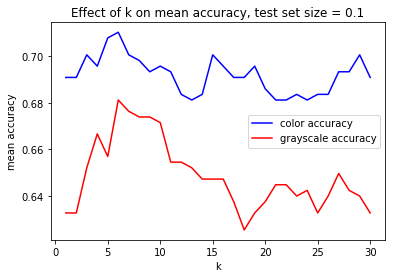

In [67]:
rgb_plot, = plt.plot(knn_metrics_rgb[0.1]['neighbors'], knn_metrics_rgb[0.1]['mean_accuracy'], label='color accuracy', color='blue')
gray_plot, = plt.plot(knn_metrics_gray[0.1]['neighbors'], knn_metrics_gray[0.1]['mean_accuracy'], label='grayscale accuracy', color='red')
plt.title("Effect of k on mean accuracy, test set size = 0.1")
plt.xlabel("k")
plt.ylabel("mean accuracy")

# show a legend
plt.legend(handles=[rgb_plot, gray_plot], loc=5)

plt.show()

# Logistic Regression
Variables: N/A

Output: accuracy score, confusion matrix

In [ ]:
# binary classifier
# test different validation set sizes
for t in test_set_sizes:
    X_train_rgb, y_train_rgb, X_test_rgb, y_test_rgb = generate_validation_sets(X_rgb, y_rgb_binary, t)
    classifier = linear_model.LogisticRegression(n_jobs=-1)
    classifier.fit(X_train_rgb, y_train_rgb)
    y_pred = classifier.predict(X_test_rgb)
    score = classifier.score(X_test_rgb, y_test_rgb)
    print("test size = %f, score = %f" % (t,score))

generating train/test split with test size = 0.1
test size = 0.100000, score = 0.746377
generating train/test split with test size = 0.2
test size = 0.200000, score = 0.745169
generating train/test split with test size = 0.3
test size = 0.300000, score = 0.760870
generating train/test split with test size = 0.4
test size = 0.400000, score = 0.757850
generating train/test split with test size = 0.5
test size = 0.500000, score = 0.761353
generating train/test split with test size = 0.6
test size = 0.600000, score = 0.758052
generating train/test split with test size = 0.7
test size = 0.700000, score = 0.767081
generating train/test split with test size = 0.8
test size = 0.800000, score = 0.746981
generating train/test split with test size = 0.9
test size = 0.900000, score = 0.750939


In [78]:
# multi-class classifier
# test different validation set sizes
for t in test_set_sizes:
    X_train_rgb, y_train_rgb, X_test_rgb, y_test_rgb = generate_validation_sets(X_rgb, y_rgb, t)
    classifier = linear_model.LogisticRegression(n_jobs=-1)
    classifier.fit(X_train_rgb, y_train_rgb)
    y_pred = classifier.predict(X_test_rgb)
    score = classifier.score(X_test_rgb, y_test_rgb)
    print("test size = %f, score = %f" % (t,score))

generating train/test split with test size = 0.1
test size = 0.100000, score = 0.676329
generating train/test split with test size = 0.2
test size = 0.200000, score = 0.676329
generating train/test split with test size = 0.3
test size = 0.300000, score = 0.673108
generating train/test split with test size = 0.4
test size = 0.400000, score = 0.681763
generating train/test split with test size = 0.5
test size = 0.500000, score = 0.669565
generating train/test split with test size = 0.6
test size = 0.600000, score = 0.680354
generating train/test split with test size = 0.7
test size = 0.700000, score = 0.676674
generating train/test split with test size = 0.8
test size = 0.800000, score = 0.661534
generating train/test split with test size = 0.9
test size = 0.900000, score = 0.651906


# Softmax Regression (precursor to CNN)

This section is largely adapted from:

https://www.tensorflow.org/get_started/mnist/pros


In [58]:
sess = tf.InteractiveSession()

# setup inputs
# x has 3072 features since it consists of 32x32 pixels
# y_ is a one-hot multi-dimensional vector the size of the number
# of classes
num_features = len(X_train_rgb[0])

x = tf.placeholder(tf.float32, [None, num_features])
y_ = tf.placeholder(tf.int32, [None, len(classes)])

# define weights (W) and biases (b)
W = tf.Variable(tf.zeros([num_features, len(classes)]))
b = tf.Variable(tf.zeros([len(classes)]))

# initialize variables
tf.global_variables_initializer().run()

In [59]:
# implement the regression model
model = tf.matmul(x, W) + b

# specify the loss function
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=model))

# use steepest gradient descent to train the model
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [60]:
# now repeatedly run train_step to perform gradient descent
offset = 0
batch_size = 100
for _ in range(1000):
    X_batch, y_batch, offset = next_batch(X_train_rgb, y_train_rgb, offset, batch_size)
    # generate one-hot encoding for the response
    y_one_hot, class_map = one_hot(y_batch, classes)
    sess.run(train_step, feed_dict={x: X_batch, y_: y_one_hot})

In [62]:
# evaluate the model
y_true = tf.argmax(y_, 1)
y_pred = tf.argmax(model, 1)

predictions = y_pred.eval(feed_dict={ x: X_test_rgb })

# define metric
correct_prediction = tf.equal(y_pred, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

y_one_hot, _ = one_hot(y_test_rgb, classes)
#print(accuracy.eval(feed_dict={x: X_test, y_: y_one_hot}))
accuracy_metric = sess.run(accuracy, feed_dict={x: X_test_rgb, y_: y_one_hot})
print("accuracy = %s" % (accuracy_metric))

sess.close()

# calculate confusion matrix
# return the predictions to class names
class_predictions = []
for pred in predictions:
    class_predictions.append(class_map[pred])
cm = metrics.confusion_matrix(y_test_rgb, np.array(class_predictions))
plot_confusion_matrix(cm, classes, title="Softmax Regression Confusion Matrix")
plt.show()

accuracy = 0.700119
Normalized confusion matrix
[[  4.78087649e-02   9.48207171e-01   3.98406375e-03]
 [  4.29922614e-03   9.94840929e-01   8.59845228e-04]
 [  7.69230769e-02   9.11538462e-01   1.15384615e-02]]


# Convolutional Neural Network

This code adapted from https://www.tensorflow.org/get_started/mnist/pros

In [4]:
# CNN Setup
sess = tf.InteractiveSession()

num_features = len(X_gray[0])
num_classes = len(classes)

# placeholders
x = tf.placeholder(tf.float32, [None, num_features])
y_ = tf.placeholder(tf.int32, [None, num_classes])

# initialize weights with small amount of noise
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# give the neurons a slightly positive bias to avoid dead neurons
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# conv2d uses stride of one and are zero-padded - output
# is the same size as the input
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# pooling is max pooling over 2x2 blocks
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1], padding='SAME')

In [5]:
# first convolutional layer
# convolution , followed by max pooling
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# reshape x to a 4d tensor
x_image = tf.reshape(x, [-1, 28, 28, 1])

# reshape x_image with weight tensor, add the bias, apply ReLU function
# finally max pool
# max_pool_2x2 reduces image to 14x14
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [6]:
# second convolutional layer
# 64 features for each 5x5 patch
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

# max_pool_2x2 reduces image size to 7x7
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [7]:
# densely connected layer
# fully-connected layer with 1024 neurons
# reshape the tnsor from the pooling layer into a batch of vectors
# multiply by weight matrix, add a bias, and apply ReLU
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [8]:
# dropout - reduces overfitting
# turned on during training, turned off during testing, controlled by the keep_prob placeholder
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [9]:
# readout layer
W_fc2 = weight_variable([1024, num_classes])
b_fc2 = bias_variable([num_classes])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [33]:
def tf_confusion_matrix(predictions, labels, classes):
    """
    produces and returns a confusion matrix given the predictions generated by
    tensorflow (in one-hot format), and string labels.
    """

    y_pred_strings = []
    labels = labels.tolist()
    
    for p in predictions:
        max_value = max(p)
        max_index = p.tolist().index(max_value)
        y_pred_strings.append(classes[max_index])
    
    #print(type(y_pred_strings))
    #print(type(labels))
    
    cm = metrics.confusion_matrix(labels, y_pred_strings)
    
    return cm
    

# train and evaluate the model
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
true_positives = tf.metrics.true_positives(y_, y_conv)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

batch_size = 50
iterations = 5000
offset = 0

accuracies = {}
best_accuracy = -1
best_test_size = -1

for t in test_set_sizes:
    sess.run(tf.global_variables_initializer())
    print("test_set_size = %g" % t)
    X_train, y_train, X_test, y_test = generate_validation_sets(X_gray, y_gray, t)

    for i in range(iterations):
        X_batch, y_batch, offset = next_batch(X_train, y_train, offset, batch_size)
        y_batch_one_hot, _ = one_hot(y_batch, classes)
        if i%200 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: X_batch, y_: y_batch_one_hot, keep_prob: 1.0 })
            print("step %d, training accuracy %g" % (i, train_accuracy))
        train_step.run(feed_dict={ x: X_batch, y_: y_batch_one_hot, keep_prob: 0.5})

    y_test_one_hot, _ = one_hot(y_test, classes)
    
    # score is mean accuracy of the classifier
    score = accuracy.eval(feed_dict={ x: X_test, y_: y_test_one_hot, keep_prob: 1.0})
    
    # create the confusion matrix
    feed_dict = {x: X_test, keep_prob: 1.0}
    classification = y_conv.eval(feed_dict)
    cm = tf_confusion_matrix(classification, y_test, classes)
    print(cm)
    accuracies[t] = score
    
    print("test accuracy %g\n" % (accuracies[t]))

print(accuracies)

test_set_size = 0.1
generating train/test split with test size = 0.1
step 0, training accuracy 0.16
step 200, training accuracy 0.7
step 400, training accuracy 0.6
step 600, training accuracy 0.74
step 800, training accuracy 0.74
step 1000, training accuracy 0.84
step 1200, training accuracy 0.82
step 1400, training accuracy 0.72
step 1600, training accuracy 0.82
step 1800, training accuracy 0.8
step 2000, training accuracy 0.9
step 2200, training accuracy 0.92
step 2400, training accuracy 0.98
step 2600, training accuracy 0.98
step 2800, training accuracy 0.96
step 3000, training accuracy 0.96
step 3200, training accuracy 0.92
step 3400, training accuracy 0.88
step 3600, training accuracy 1
step 3800, training accuracy 0.98
step 4000, training accuracy 0.96
step 4200, training accuracy 0.98
step 4400, training accuracy 0.98
step 4600, training accuracy 1
step 4800, training accuracy 0.98
[[ 19   3  17   4]
 [  8 210  14   4]
 [ 13  11  40   4]
 [ 13   4  14  36]]
test accuracy 0.73671

KeyboardInterrupt: 